# DRL Course 2023 Домашнее задание 4 #

Отчет по выполнению домашнего задания, Nikita Sorokin

In [1]:
import numpy as np
import gym
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

sns.set()

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [2]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif', fps=60):

    plt.figure(figsize=(frames[0].shape[1] / 50.0, frames[0].shape[0] / 50.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=fps)

## Используемые алгоритмы

### Cross-Entropy Method

Пусть $ \pi_0 $ начальная политика, N число итераций алгоритма, $ q \in (0, \, 1) $ - уровень квантиля. Для $ n \in \overline{0, N} $:

* (Policy evaluation)

$$
\mathbb{E}_{\pi_n} [G] \approx V_{\pi_n} := \frac{1}{K} \sum_{k = 1}{K} G(\tau_k)
$$

* (Policy improvement) Выбираем "элитные" траектории $ \Tau_n = \{\tau_k, \, k \in \overline{1,K}: \, G(\tau_k) > \gamma_k \} $.

Обновляем политику как:

$$
\pi_{n+1} (a|s) = \frac{|(a|s) \in \Tau_n|}{|s \in \Tau_n|}
$$

In [4]:
class CrossEntropyAgent():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.model = np.ones((self.state_n, self.action_n)) / self.action_n

    def get_action(self, state):
        action = np.random.choice(np.arange(self.action_n), p=self.model[state])
        return int(action)
    
    def fit(self, elite_trajectories):
        new_model = np.zeros((self.state_n, self.action_n))
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                new_model[state][action] += 1
            
        for state in range(self.state_n):
            if np.sum(new_model[state]) > 0:
                new_model[state] /= np.sum(new_model[state])
            else:
                new_model[state] = self.model[state].copy()

        self.model = new_model
        return None

    def get_state(self, obs):
        return obs

In [5]:
def get_trajectory(env, agent, trajectory_len=500, visualize=False, filename='gym_animation.gif', fps=60):

    trajectory = {'states': [], 'actions': [], 'rewards': []}

    obs = env.reset()
    state = agent.get_state(obs)

    frames = []
    for i in range(trajectory_len):

        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        obs, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)

        state = agent.get_state(obs)

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

In [6]:
def train(env, agent, q_param, iteration_n, trajectory_n):
    all_rewards = []
    for iteration in tqdm(range(iteration_n)):

        # policy evaluation
        trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
        total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
        all_rewards.extend(total_rewards)

        # policy improvement
        quantile = np.quantile(total_rewards, q_param)
        elite_trajectories = []
        for trajectory in trajectories:
            total_reward = np.sum(trajectory['rewards'])
            if total_reward > quantile:
                elite_trajectories.append(trajectory)

        agent.fit(elite_trajectories)

    return all_rewards

### $\varepsilon$-Greedy Policy:



$$
\begin{array}{l}
\pi(a|s) =
\left\{
\begin{array}{ll}
1 - \varepsilon + \varepsilon / m,& \text{ если } a \in \mathrm{argmax}_{a' \in \mathcal{A}}\, Q(s,a'),\\
\varepsilon / m,& \text{ иначе }
\end{array}
\right.
\end{array}
$$

In [7]:
def get_epsilon_greedy_action(q_values_state, action_n, epsilon=0):
    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values_state)
    return np.random.choice(np.arange(action_n), p=policy)

### Дискретизация

Используется для выполения задания №2. Основная идея состоит в следующем: непрерывное пространство состояний аппроксимируем конечной сеткой значений. Однако это не значит, что управляемый объект может двигаться только по конечному числу точек. Это лишь значит, что оказавшись в некотором состоянии агент выбирает действие не по настоящему значению состояния, а по ближайшей к нему точки на сетке.

In [8]:
def get_discrete_state(state, state_space, points_n, state_dim):
    state_idx = 0
    for i in range(state_dim):
        min_idx = np.abs(state_space[i] - state[i]).argmin()
        state[i] = state_space[i, min_idx]
        state_idx += min_idx * points_n**i

    return state, state_idx 

### Agent class

Создан для того чтобы использовать ранее написанные для CrossEntropyAgent() функции get_trajectory() и validation() для новых алгоритмов.

In [1]:
class Agent():
    def __init__(self, env, state_n, action_n, continuous_state=False, point_n=10):
        self.state_n = state_n
        self.action_n = action_n
        self.continuous_state = continuous_state
        self.point_n = point_n

        self.known_model = False
        self.q_values = np.zeros((self.state_n, self.action_n))
        self.model = np.ones((self.state_n, self.action_n)) / self.action_n

        if continuous_state == False:
            self.state_n = env.observation_space.n
            
        if continuous_state == True:
            self.state_dim = env.observation_space.shape[0]
            low = env.observation_space.low
            high = env.observation_space.high
            self.state_space = np.linspace(low[0], high[0], point_n)
            for i in range(1, low.shape[0]):
                new_dim_space = np.linspace(low[i], high[i], point_n)
                self.state_space = np.vstack((self.state_space, new_dim_space))

            self.state_n = point_n**(self.state_dim)


    def get_action(self, state, known_model=True):
        if self.known_model == True:
            action = np.random.choice(np.arange(self.action_n), p=self.model[state])

        if self.known_model == False:
            action = get_epsilon_greedy_action(self.q_values[state], self.action_n, epsilon=0)

        return int(action)


    def get_model(self, q_values, epsilon=0):
        self.model = np.zeros((self.state_n, self.action_n))
        for i in tqdm(range(self.state_n)):
            action = get_epsilon_greedy_action(q_values[i], self.action_n, epsilon)
            self.model[i, :] = epsilon / self.action_n
            self.model[i, action] = 1 - epsilon + epsilon / self.action_n
            
        self.known_model = True

    def get_q_values(self, q_values):
        self.q_values = q_values

    def get_state(self, obs):
        state = obs
        if self.continuous_state == True:
            _, state = get_discrete_state(state, self.state_space, self.point_n, self.state_dim)

        return state

In [10]:
def validation(env, agent, trajectory_len, validation_n):
    total_rewards = []
    for _ in range(validation_n):
        trajectory = get_trajectory(env, agent, trajectory_len)
        total_rewards.append(np.sum(trajectory['rewards']))

    return np.mean(total_rewards)


### Monte-Carlo Algorithm



Пусть $Q(s,a) = 0$, $N(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k \in \overline{1,K}$ делаем:

1. Согласно $\pi = \varepsilon\text{-greedy}(Q)$ получаем траекторию $\tau = (S_0,A_0,\ldots,S_T)$ и награды $(R_0,\ldots,R_{T-1})$. По ним определяем $(G_0,\ldots,G_{T-1}):$
$$
G_t = \sum\limits_{k=t}^{T-1} \gamma^{k-t} R_t,\quad G_{T-1} = R_{T-1},\quad G_{T-2} = R_{T-2} + \gamma R_{T-1},\quad G_i = R_i + \gamma G_{i+1},\quad G_{T} = Q(S_T,\pi_{greedy}(S_T)).
$$

2. Для каждого $t \in \overline{0,T-1}$ обновляем $Q$ и $N$:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t) + 1}\big(G_t - Q(S_t,A_t)\big),
$$

$$
N(S_t,A_t) \leftarrow N(S_t,A_t) + 1
$$
Уменьшаем $\varepsilon$

In [32]:
def MonteCarlo(env, episode_n, trajectory_len=500, gamma=0.99, alpha=0, continuous_state=False, point_n=10, 
               eps_strategy=lambda x, n: 1 - x / n, q_initial=np.zeros(0)):
    total_rewards = []
    
    if continuous_state == False:
        state_n = env.observation_space.n
        
    if continuous_state == True:
        state_dim = env.observation_space.shape[0]
        low = env.observation_space.low
        high = env.observation_space.high
        state_space = np.linspace(low[0], high[0], point_n)
        for i in range(1, low.shape[0]):
            new_dim_space = np.linspace(low[i], high[i], point_n)
            state_space = np.vstack((state_space, new_dim_space))

        state_n = point_n**(state_dim)

    action_n = env.action_space.n
    
    if q_initial.size == 0:
        qfunction = np.random.random((state_n, action_n))
    else:
        qfunction = q_initial
        
    counter = np.zeros((state_n, action_n))
    
    for episode in tqdm(range(episode_n)):
        epsilon = eps_strategy(episode, episode_n)

        trajectory = {'states': [], 'actions': [], 'rewards': []}
        
        state = env.reset()
        for _ in range(trajectory_len):
            trajectory['states'].append(state)
            
            if continuous_state == True:
                _, state = get_discrete_state(state, state_space, point_n, state_dim)

            action = get_epsilon_greedy_action(qfunction[state], action_n, epsilon)
            trajectory['actions'].append(action)
            
            state, reward, done, _ = env.step(action)
            trajectory['rewards'].append(reward)
            
            if done:
                break
                
        total_rewards.append(sum(trajectory['rewards']))

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]
            
        for t in range(real_trajectory_len):

            if continuous_state == False:
                state = trajectory['states'][t]

            if continuous_state == True:
                state = trajectory['states'][t]
                _, state = get_discrete_state(state, state_space, point_n, state_dim)

            action = trajectory['actions'][t]

            if alpha == 0:
                qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            
            if alpha != 0:
                qfunction[state][action] += alpha * (returns[t] - qfunction[state][action])

            counter[state][action] += 1
            
    return total_rewards, qfunction


### SARSA Algorithm 

Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$, переходим в состояние $S_{t+1}$, совершаем действие $A_{t+1} \sim \pi(\cdot|S_{t+1})$

2. По $(S_t,A_t,R_t,S_{t+1},A_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$

In [107]:
def SARSA(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5, continuous_state=False,
          point_n = 10, eps_strategy=lambda x, n: 1 / (x + 1)):
          
    total_rewards = np.zeros(episode_n)
    
    if continuous_state == False:
        state_n = env.observation_space.n
        
    if continuous_state == True:
        state_dim = env.observation_space.shape[0]
        low = env.observation_space.low
        high = env.observation_space.high
        state_space = np.linspace(low[0], high[0], point_n)
        for i in range(1, low.shape[0]):
            new_dim_space = np.linspace(low[i], high[i], point_n)
            state_space = np.vstack((state_space, new_dim_space))
        state_n = point_n**(state_dim)

    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    
    for episode in tqdm(range(episode_n)):
        
        epsilon = eps_strategy(episode, episode_n)
        state = env.reset()
        if continuous_state == True:
            _, state = get_discrete_state(state, state_space, point_n, state_dim)
        action = get_epsilon_greedy_action(qfunction[state], action_n, epsilon)
        
        for _ in range(trajectory_len):

            next_state, reward, done, _ = env.step(action)
            if continuous_state == True:
                _, next_state = get_discrete_state(next_state, state_space, point_n, state_dim)
            next_action = get_epsilon_greedy_action(qfunction[next_state], action_n, epsilon)
            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])
            state = next_state
            action = next_action
            total_rewards[episode] += reward
            
            if done:
                break

    return total_rewards, qfunction


### Q-Learning Algorithm


Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$.

2. По $(S_t,A_t,R_t,S_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma \max\limits_{a'} Q(S_{t+1},a') - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$

In [12]:
def QLearning(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5, continuous_state=False,
              point_n = 10, eps_strategy=lambda x, n: 1 / (x + 1), q_initial=np.zeros(0)):

    total_rewards = np.zeros(episode_n)
    
    if continuous_state == False:
        state_n = env.observation_space.n
        
    if continuous_state == True:
        state_dim = env.observation_space.shape[0]
        low = env.observation_space.low
        high = env.observation_space.high
        state_space = np.linspace(low[0], high[0], point_n)
        for i in range(1, low.shape[0]):
            new_dim_space = np.linspace(low[i], high[i], point_n)
            state_space = np.vstack((state_space, new_dim_space))
        state_n = point_n**(state_dim)

    action_n = env.action_space.n
    if q_initial.size == 0:
        qfunction = np.zeros((state_n, action_n))
    else:
        qfunction = q_initial
    
    for episode in tqdm(range(episode_n)):
        epsilon = eps_strategy(episode, episode_n)
        
        state = env.reset()
        if continuous_state == True:
            _, state = get_discrete_state(state, state_space, point_n, state_dim)

        action = get_epsilon_greedy_action(qfunction[state], action_n, epsilon)
        for _ in range(trajectory_len):
            next_state, reward, done, _ = env.step(action)
            if continuous_state == True:
                _, next_state = get_discrete_state(next_state, state_space, point_n, state_dim)
            
            qfunction[state][action] += alpha * (reward + gamma * np.max(qfunction[next_state][:]) - qfunction[state][action])
            
            state = next_state
            action = get_epsilon_greedy_action(qfunction[next_state], action_n, epsilon)
            
            total_rewards[episode] += reward
            
            if done:
                break

    return total_rewards, qfunction

## Задание 1 ##

Реализовать Q-Learning и сравнить его результаты с реализованными ранее алгоритмами Cross-Entropy, Monte Carlo, SARSA в задаче Taxi-v3. Для сравнения как минимум нужно использовать графики обучения.  

In [276]:
env = gym.make("Taxi-v3")

state_n = 500
action_n = 6

### Cross-Entropy

Алгоритм сходится к validation_score = 6.636 за ~40 секунд при следующих гиперпараметрах (которые были получены в домашнем задании №1):

```python

q_param = 0.6
iteration_n = 20
trajectory_n = 500

```

In [193]:
CE_agent = CrossEntropyAgent(state_n, action_n)

In [194]:
q_param = 0.6
iteration_n = 20
trajectory_n = 500

In [195]:
ce_rewards = train(env, CE_agent, q_param, iteration_n, trajectory_n)

100%|██████████| 20/20 [01:03<00:00,  3.18s/it]


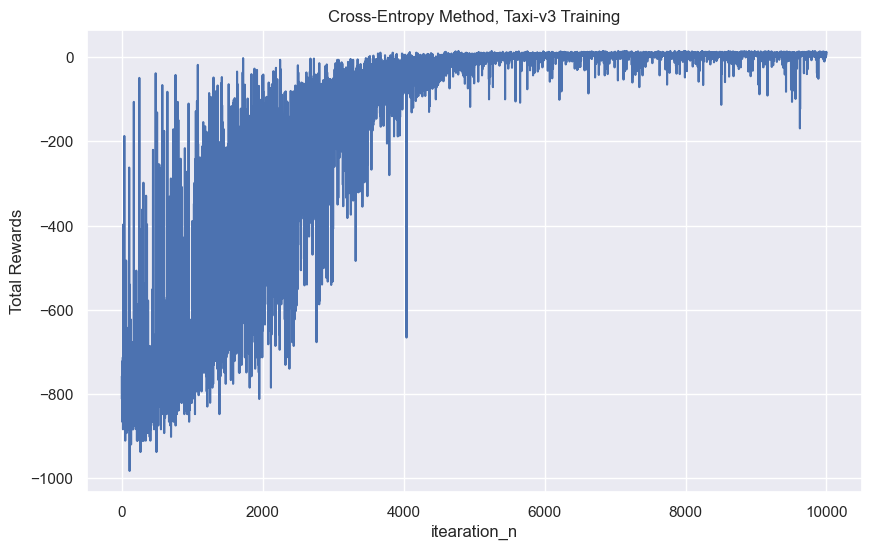

In [202]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Cross-Entropy Method, Taxi-v3 Training')
axs.set_xlabel('itearation_n')
axs.set_ylabel('Total Rewards')

plt.plot(ce_rewards)
#plt.savefig('ce_taxi.png')

In [211]:
validation_n = 1000
validation_score = validation(env, CE_agent, validation_n=validation_n, trajectory_len=100)
print(f'Cross-Entropy method validation_score: {validation_score}')

Cross-Entropy method validation_score: 5.983


Сохранение и загрузка модели:

In [212]:
#np.save('ce_taxi.npy', CE_agent.model)
#CE_agent.model = np.load('ce_taxi.npy', allow_pickle=True)

### Monte Carlo

Более детальное ислледование в задании №3.

In [227]:
episode_n = 5000
gamma = 0.9
trajectory_len = 100

In [228]:
def grid_search(gamma):

    fig, axs = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, layout="constrained")

    names = [r"$ \gamma =  $" + f"{gamma[i]}" for i in range(gamma.size)]

    mc_rewards_gamma = []
    mc_q_values_gamma = []
    for i in range(gamma.size):
        mc_rewards, mc_q_values = MonteCarlo(env, episode_n, trajectory_len, gamma[i])
        mc_rewards_gamma.append(mc_rewards)
        mc_q_values_gamma.append(mc_q_values)

        axs[i // 3, i % 3].plot(mc_rewards, label=names[i])
        axs[i // 3, i % 3].set_xlabel('iteration')
        axs[i // 3, i % 3].set_ylabel('total reward')
        axs[i // 3, i % 3].legend()

    return mc_rewards_gamma, mc_q_values_gamma

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:38<00:00, 130.85it/s]


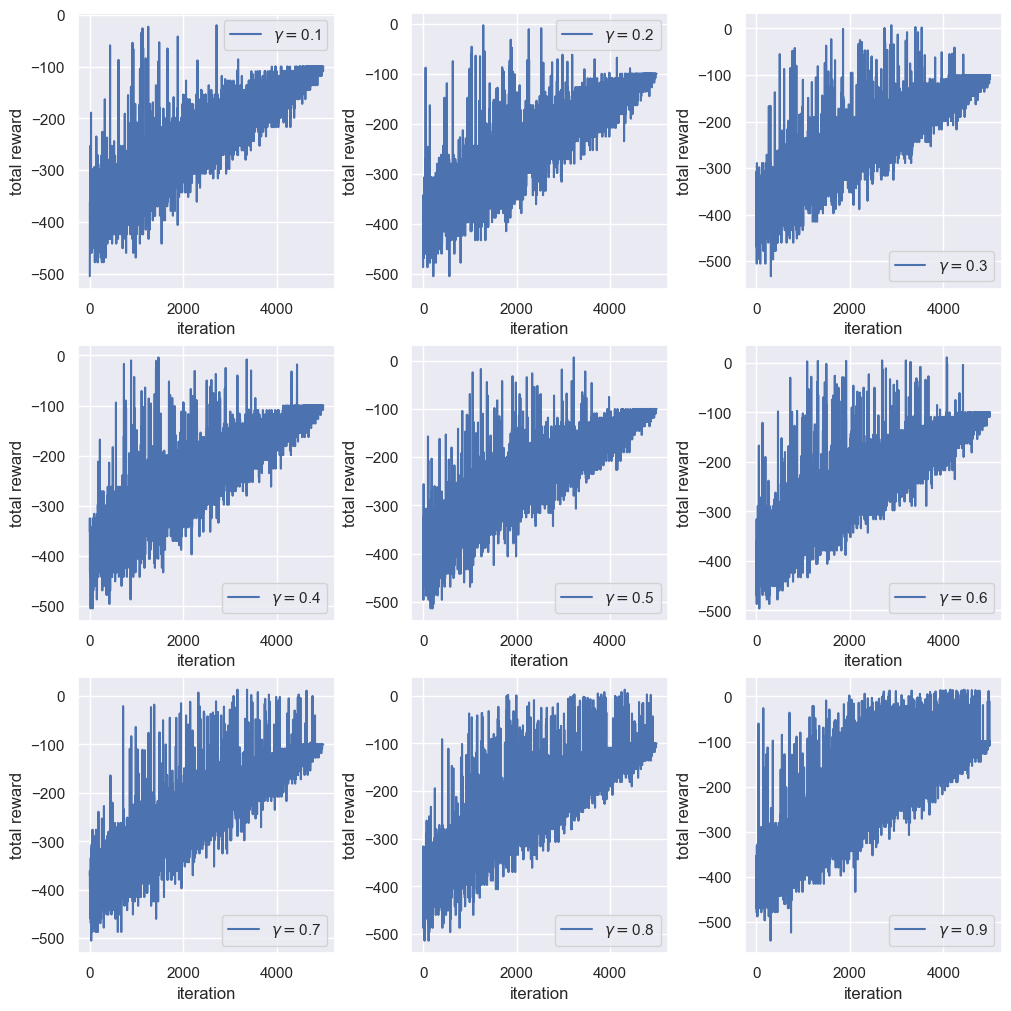

In [229]:
gamma = np.round(np.linspace(0.1, 0.9, 9), decimals=1)

mc_rewards_gamma, mc_q_values_gamma = grid_search(gamma)

In [ ]:
validation_n = 1000

for i in range(9):

    MC_agent = Agent(env, state_n, action_n)
    MC_agent.get_model(mc_q_values_gamma[i])
    validation_score = validation(env, MC_agent, validation_n=validation_n, trajectory_len=100)
    print(f'Monte Carlo algorithm validation_score, gamma = {gamma[i]}: {validation_score}')

Monte Carlo algorithm validation_score, gamma = 0.1: -100.0
Monte Carlo algorithm validation_score, gamma = 0.2: -100.0
Monte Carlo algorithm validation_score, gamma = 0.3: -100.0
Monte Carlo algorithm validation_score, gamma = 0.4: -100.0
Monte Carlo algorithm validation_score, gamma = 0.5: -100.0
Monte Carlo algorithm validation_score, gamma = 0.6: -100.0
Monte Carlo algorithm validation_score, gamma = 0.7: -100.0
Monte Carlo algorithm validation_score, gamma = 0.8: -100.0
Monte Carlo algorithm validation_score, gamma = 0.9: -98.183


Наилучший параметр $ \gamma = 0.9 $!

In [236]:
mc_rewards = mc_rewards_gamma[-1]

In [232]:
MC_agent = Agent(env, state_n, action_n)
MC_agent.get_model(mc_q_values_gamma[-1])

MovieWriter imagemagick unavailable; using Pillow instead.


trajectory rewards: -100


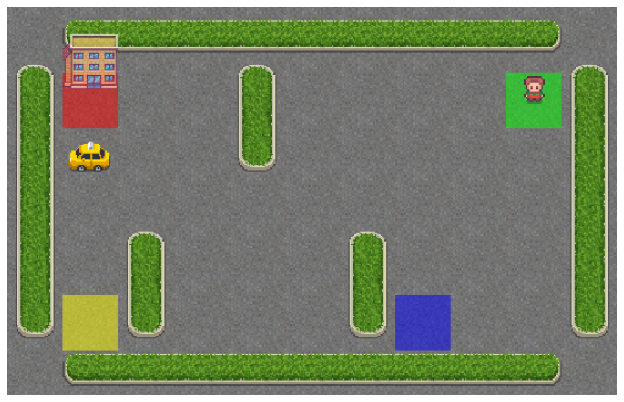

In [235]:
trajectory = get_trajectory(env, MC_agent, trajectory_len=100, visualize=True, filename='mc_taxi.gif')

print(f"trajectory rewards: {np.sum(trajectory['rewards'])}")

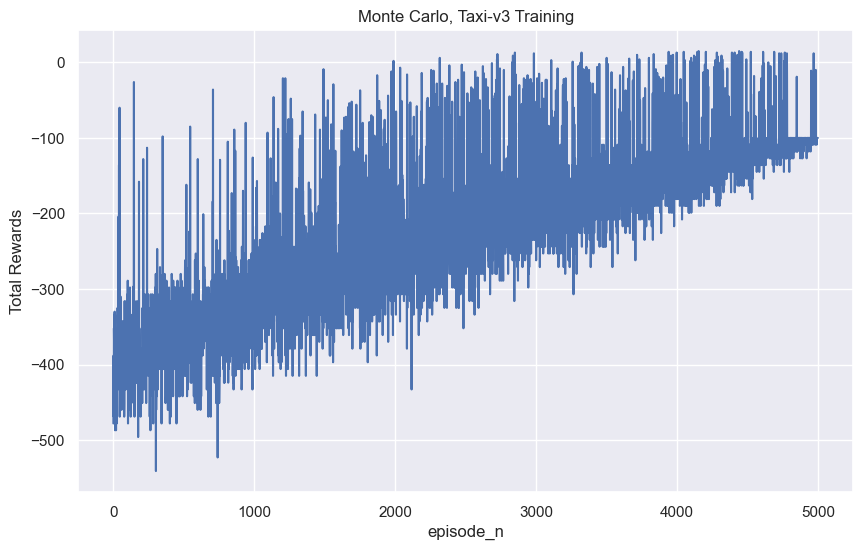

In [238]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Monte Carlo, Taxi-v3 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Total Rewards')

plt.plot(mc_rewards)
plt.savefig('mc_taxi.png')

In [240]:
#np.save('mc_taxi.npy', MC_agent.model)
#MC_agent.model = np.load('mc_taxi.npy', allow_pickle=True)

### SARSA

Алгоритм сходится к validation_score = 7.807 за 4 секунды при следующих гиперпараметрах:

```python

episode_n = 2000
gamma = 0.9
trajectory_len = 100
alpha = 0.5

```

In [241]:
episode_n = 2000
gamma = 0.9
trajectory_len = 100
alpha = 0.5

In [242]:
sarsa_rewards, sarsa_q_values = SARSA(env, episode_n, gamma, trajectory_len, alpha)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:04<00:00, 492.63it/s]


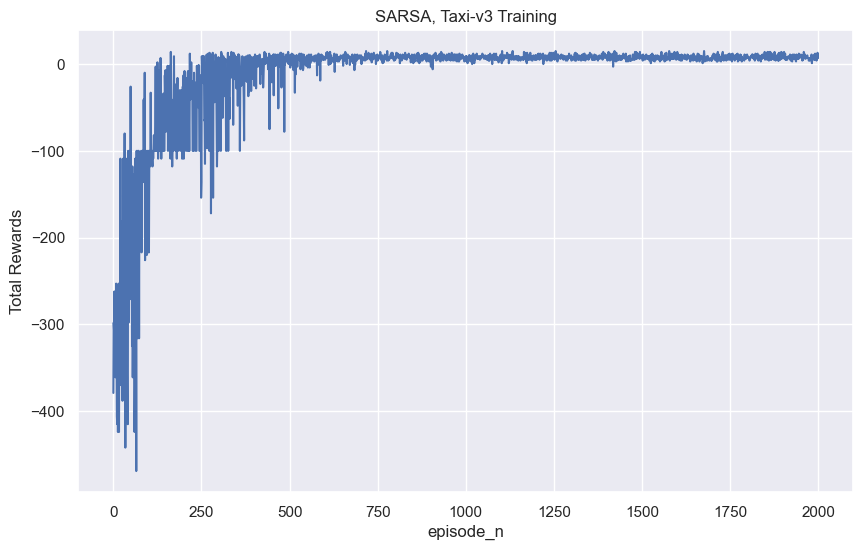

In [252]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('SARSA, Taxi-v3 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Total Rewards')

plt.plot(sarsa_rewards)
plt.savefig('sarsa_taxi.png')

In [244]:
SARSA_agent = Agent(env, state_n, action_n)
SARSA_agent.get_model(sarsa_q_values)

In [246]:
validation_n = 100
validation_score = validation(env, SARSA_agent, trajectory_len, validation_n)
print(f'SARSA validation_score: {validation_score}')

SARSA validation_score: 8.05


MovieWriter imagemagick unavailable; using Pillow instead.


trajectory rewards: 11


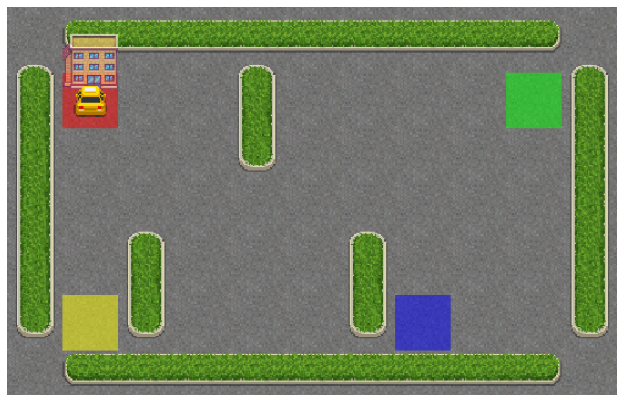

In [247]:
trajectory = get_trajectory(env, SARSA_agent, trajectory_len, visualize=True, filename='sarsa_taxi.gif')

print(f"trajectory rewards: {np.sum(trajectory['rewards'])}")

Сохранение и загрузка модели:

In [248]:
#np.save('sarsa_taxi.npy', SARSA_agent.model)
#CE_agent.model = np.load('ce_taxi.npy', allow_pickle=True)

### Q-learning

Алгоритм сходится к validation_score = 7.853 за 4 секунды при следующих гиперпараметрах:

```python

episode_n = 2000
gamma = 0.9
trajectory_len = 100
alpha = 0.5

```

In [249]:
episode_n = 2000
gamma = 0.9
trajectory_len = 100
alpha = 0.5

In [250]:
q_rewards, q_q_values = QLearning(env, episode_n, gamma, trajectory_len, alpha)

100%|██████████| 2000/2000 [00:04<00:00, 458.09it/s]


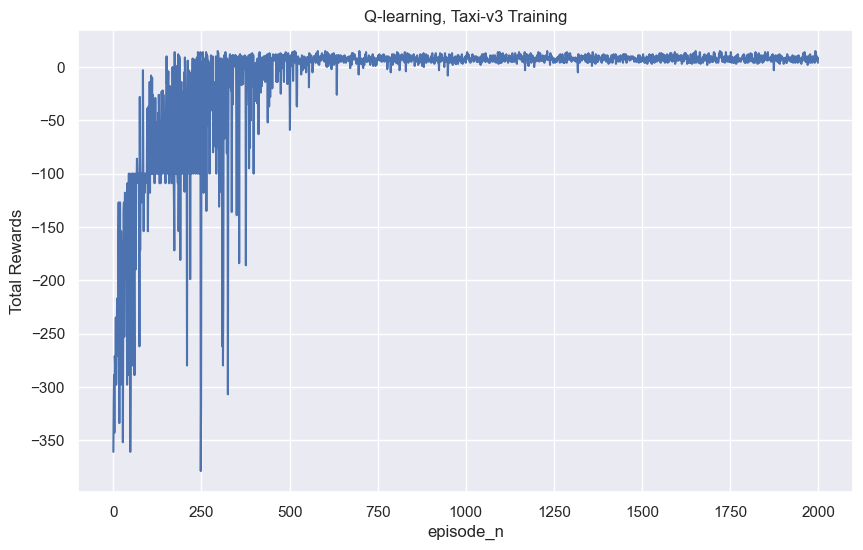

In [253]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Q-learning, Taxi-v3 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Total Rewards')

plt.plot(q_rewards)
plt.savefig('q_taxi.png')

In [254]:
Q_agent = Agent(env, state_n, action_n)
Q_agent.get_model(q_q_values)

In [255]:
validation_n = 1000
validation_score = validation(env, Q_agent, trajectory_len, validation_n)
print(f'Q-learning validation_score: {validation_score}')

Q-learning validation_score: 7.092


MovieWriter imagemagick unavailable; using Pillow instead.


trajectory rewards: 6


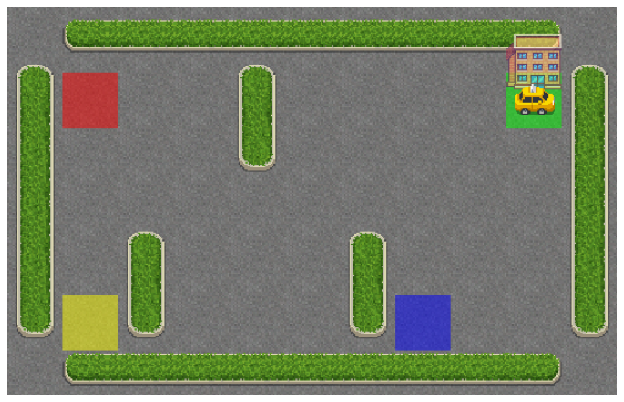

In [256]:
trajectory = get_trajectory(env, Q_agent, trajectory_len, visualize=True, filename='q_taxi.gif')

print(f"trajectory rewards: {np.sum(trajectory['rewards'])}")

In [259]:
#np.save('q_taxi.npy', Q_agent.model)
#CE_agent.model = np.load('ce_taxi.npy', allow_pickle=True)

Изучим гиперпараметр $ \alpha $:

In [279]:
episode_n = 1000
gamma = 0.9
trajectory_len = 100

In [285]:
def grid_search(alpha):

    fig, axs = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, layout="constrained")

    names = [r"$ \alpha =  $" + f"{alpha[i]}" for i in range(alpha.size)]

    q_rewards_alpha = []
    q_q_values_alpha = []
    for i in range(alpha.size):
        q_rewards, q_q_values = QLearning(env, episode_n, gamma, trajectory_len, alpha[i])
        q_rewards_alpha.append(q_rewards)
        q_q_values_alpha.append(q_q_values)

        axs[i // 3, i % 3].plot(q_rewards, label=names[i])
        axs[i // 3, i % 3].set_xlabel('iteration')
        axs[i // 3, i % 3].set_ylabel('total reward')
        axs[i // 3, i % 3].legend()

    return q_rewards_alpha, q_q_values_alpha

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 484.68it/s]


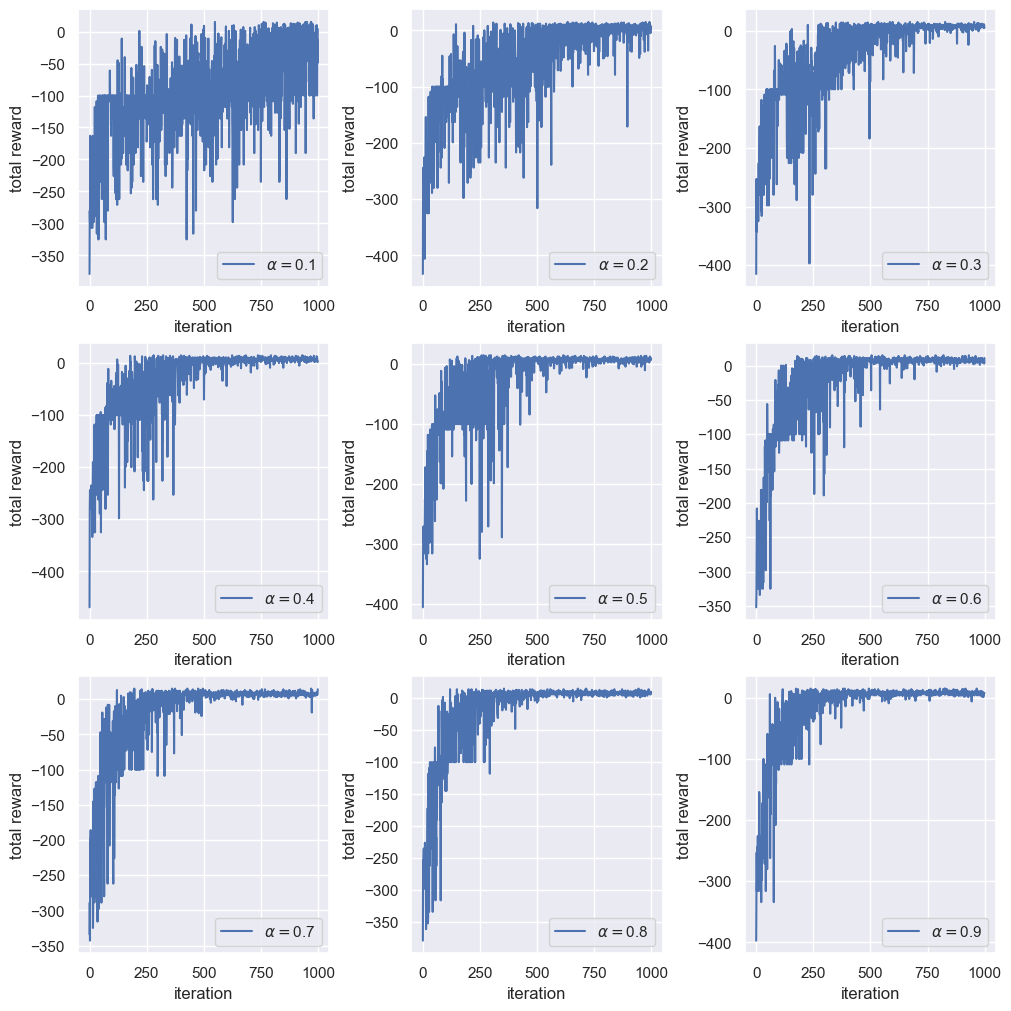

In [286]:
alpha = np.round(np.linspace(0.1, 0.9, 9), decimals=1)

q_rewards_alpha, q_q_values_alpha = grid_search(alpha)

In [291]:
validation_n = 1000

for i in range(9):

    Q_agent = Agent(env, state_n, action_n)
    Q_agent.get_model(q_q_values_alpha[i])
    validation_score = validation(env, Q_agent, validation_n=validation_n, trajectory_len=100)
    print(f'Q-learning algorithm validation_score, alpha = {alpha[i]}: {validation_score}')

Q-learning algorithm validation_score, alpha = 0.1: -126.108
Q-learning algorithm validation_score, alpha = 0.2: -44.184
Q-learning algorithm validation_score, alpha = 0.3: -16.632
Q-learning algorithm validation_score, alpha = 0.4: 1.725
Q-learning algorithm validation_score, alpha = 0.5: 1.455
Q-learning algorithm validation_score, alpha = 0.6: 0.796
Q-learning algorithm validation_score, alpha = 0.7: -5.562
Q-learning algorithm validation_score, alpha = 0.8: 6.06
Q-learning algorithm validation_score, alpha = 0.9: 3.496


Наилучший параметр $ \alpha = 0.8 $!

### Сравнение алгоритмов

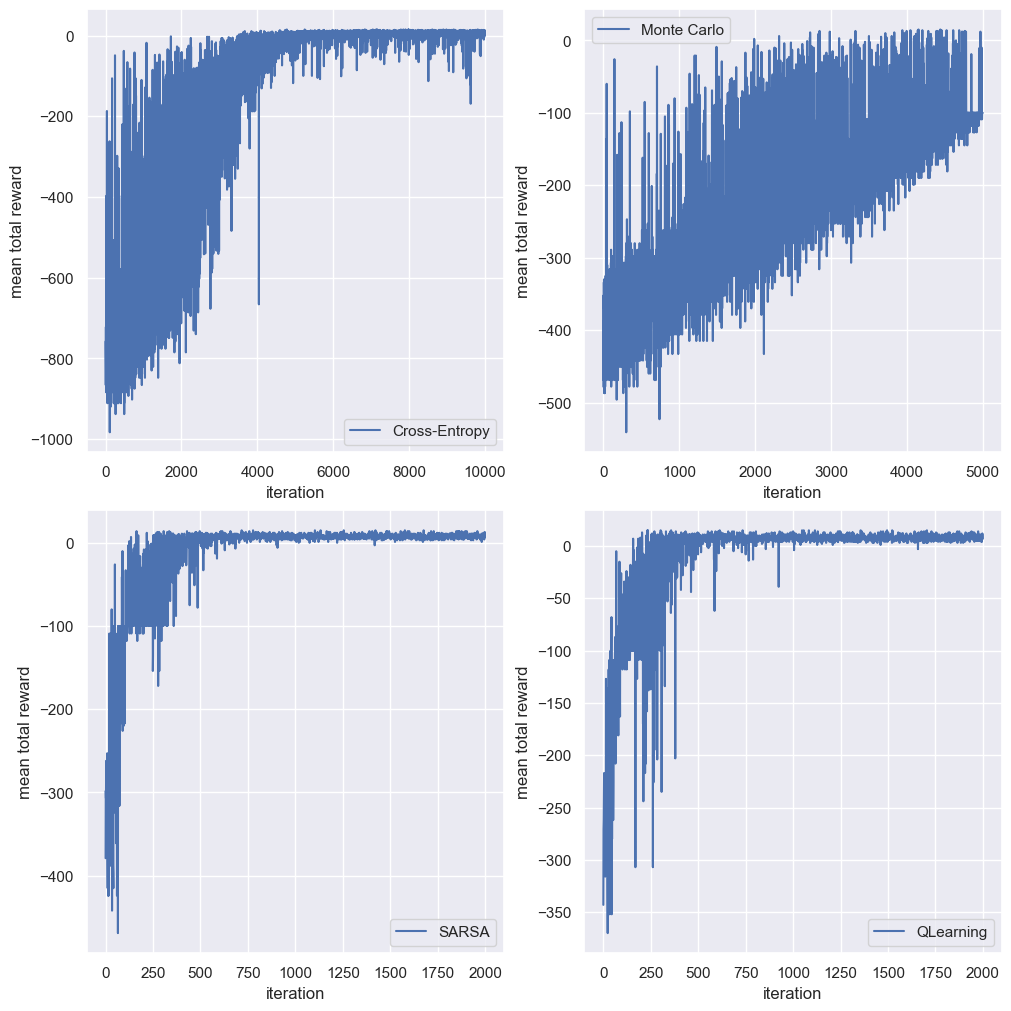

In [292]:
fig, axs = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, layout="constrained")

names = ['Cross-Entropy', 'Monte Carlo', 'SARSA', 'QLearning']
rewards = [ce_rewards, mc_rewards, sarsa_rewards, q_rewards]

for i in range(4):
    axs[i // 2, i % 2].plot(rewards[i], label=names[i])
    axs[i // 2, i % 2].set_xlabel('iteration')
    axs[i // 2, i % 2].set_ylabel('mean total reward')
    axs[i // 2, i % 2].legend()

plt.savefig('taxi_comparison.png')

## Задание 2 ##

Дискретизировать (можно использовать numpy.round()) пространство состояний и обучить Агента решать CartPole-v1, Acrobot-v1, MountainCar-v0, или LunarLander-v2 (одну на выбор) методами Monte Carlo, SARSA и Q-Learning. Сравнить результаты этих алгоритмов и реализованного ранее алгоритма Deep Cross-Entropy на графиках. 

### MountainCar-v0

Гипотеза: обучить MountainCar-v0 будет проще и быстрее других сред, поскольку у него наименьшая размерность пространства состояний. Поскольку количество точек сетки растет экспоненциально относительно размерности дискретизируемого пространства, а размерность состояний MountainCar-v0 равна 2 (В Acrobot'e даже не хватает 8гб оперативной памяти, чтобы создать сетку с 30 точками разбиения по каждой координате: 30^6=729000000).

Так что начнем с этой среды!

In [15]:
env = gym.make('MountainCar-v0')
state_dim = 2
action_n = 3

### Q-learning

Выберем оптимальный параметр дискритизации - point_n (количество точек разбиения пространства состояний).

In [408]:
episode_n = 15000
gamma = 0.95
trajectory_len = 200
alpha = 0.2
point_n = 20

In [ ]:
def grid_search(points_n):

    fig, axs = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, layout="constrained")

    names = ["point_n =" + f"{points_n[i]}" for i in range(points_n.size)]

    q_rewards_points_n = []
    q_q_values_points_n = []
    for i in range(points_n.size):
        q_rewards, q_q_values = QLearning(env, episode_n, gamma, trajectory_len, alpha, continuous_state=True, point_n=points_n[i])
        q_rewards_points_n.append(q_rewards)
        q_q_values_points_n.append(q_q_values)

        axs[i // 2, i % 2].plot(q_rewards, label=names[i])
        axs[i // 2, i % 2].set_xlabel('iteration')
        axs[i // 2, i % 2].set_ylabel('total reward')
        axs[i // 2, i % 2].legend()

    return q_rewards_points_n, q_q_values_points_n

In [393]:
points_n = np.array([5, 10, 20, 40])

  0%|          | 0/15000 [00:00<?, ?it/s]

100%|██████████| 15000/15000 [03:48<00:00, 65.70it/s]


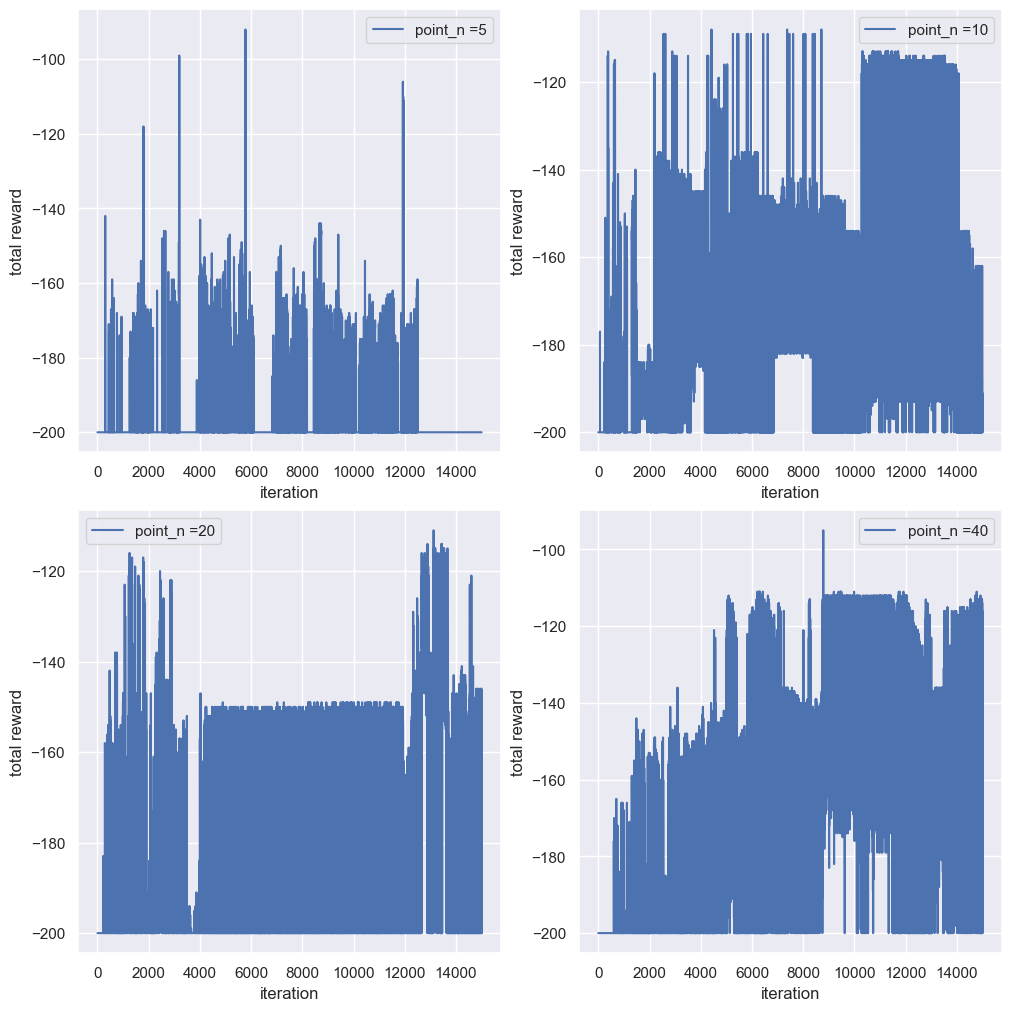

In [394]:
q_rewards_points_n, q_q_values_points_n = grid_search(points_n)

In [397]:
validation_n = 1000

for i in range(4):

    Q_agent = Agent(env, state_n, action_n, continuous_state=True, point_n=points_n[i])
    Q_agent.get_model(q_q_values_points_n[i])
    validation_score = validation(env, Q_agent, validation_n=validation_n, trajectory_len=200)
    print(f'Q-learning algorithm validation_score, point_n = {points_n[i]}: {validation_score}')

100%|██████████| 25/25 [00:00<00:00, 12523.30it/s]


Q-learning algorithm validation_score, point_n = 5: -200.0


100%|██████████| 100/100 [00:00<00:00, 4539.04it/s]


Q-learning algorithm validation_score, point_n = 10: -194.83


100%|██████████| 400/400 [00:00<00:00, 1869.00it/s]


Q-learning algorithm validation_score, point_n = 20: -175.749


100%|██████████| 1600/1600 [00:00<00:00, 2666.44it/s]


Q-learning algorithm validation_score, point_n = 40: -170.71


points_n = 40 самый удачный, доучим еще 15000 эпизодов.

In [409]:
q_rewards, q_q_values = QLearning(env, episode_n, gamma, trajectory_len, alpha, continuous_state=True, 
                                  point_n=40, q_initial=q_q_values_points_n[-1], eps_strategy=eps8)

100%|██████████| 15000/15000 [04:12<00:00, 59.32it/s]


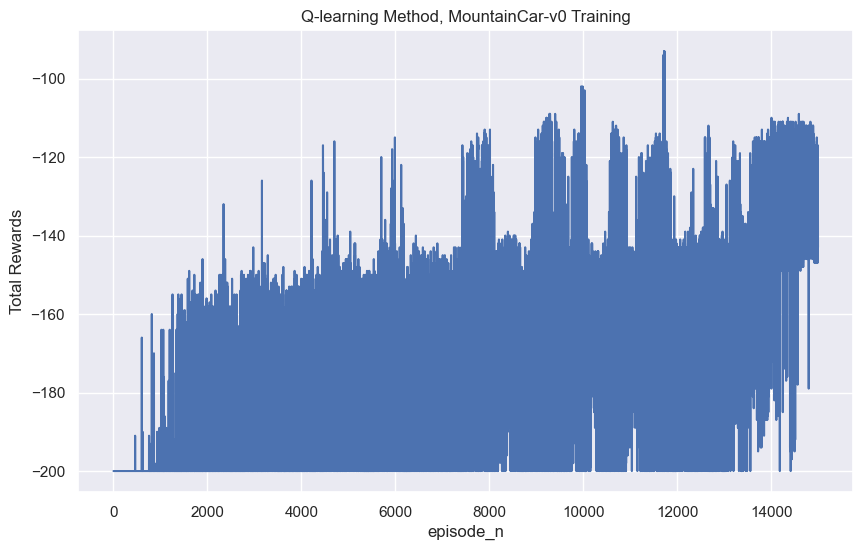

In [419]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Q-learning Method, MountainCar-v0 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Total Rewards')

plt.plot(q_rewards)
#plt.savefig('q_car.png')

In [414]:
Q_agent = Agent(env, state_n, action_n, continuous_state=True, point_n=40)
Q_agent.get_model(q_q_values)

100%|██████████| 1600/1600 [00:00<00:00, 21333.79it/s]


In [415]:
validation_n = 1000
validation_score = validation(env, Q_agent, trajectory_len, validation_n)
print(f'Q-learning algorithm validation_score: {validation_score}')

Q-learning algorithm validation_score: -131.826


MovieWriter imagemagick unavailable; using Pillow instead.


-119.0


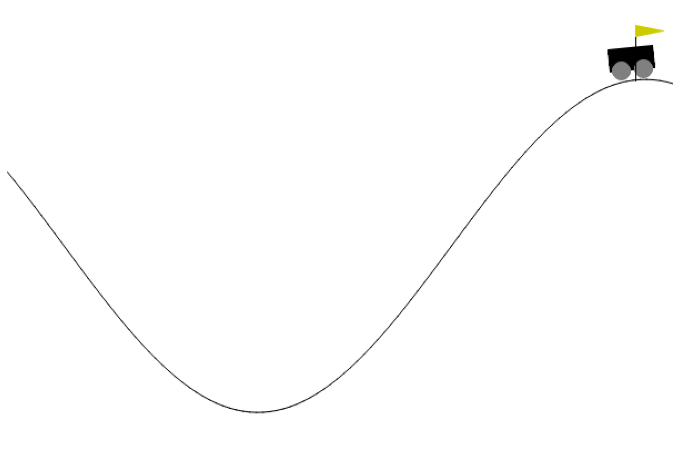

In [418]:
trajectory = get_trajectory(env, Q_agent, trajectory_len, visualize=True, filename='q_car.gif', fps=120)

print(np.sum(trajectory['rewards']))

In [420]:
#np.save('q_car.npy', q_q_values)
#CE_agent.model = np.load('ce_taxi.npy', allow_pickle=True)

### SARSA

Параметры полученные для Q-learning'а хорошо работают и для алгоритма SARSA. Будем учиться 30000 эпизодов.

In [421]:
episode_n = 30000
gamma = 0.95
trajectory_len = 200
alpha = 0.2

In [422]:
sarsa_rewards, sarsa_q_values = QLearning(env, episode_n, gamma, trajectory_len, alpha, continuous_state=True, 
                                          point_n=40, eps_strategy=eps8)

100%|██████████| 30000/30000 [09:27<00:00, 52.87it/s]


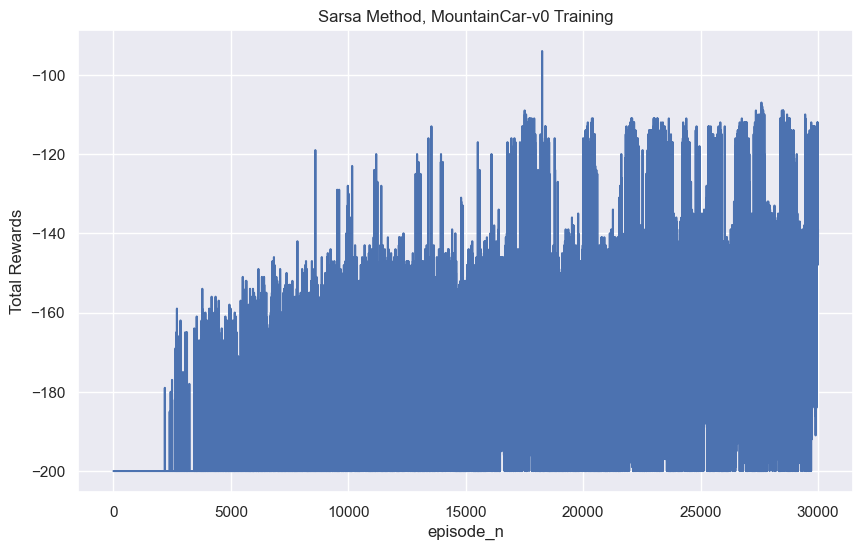

In [423]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Sarsa Method, MountainCar-v0 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Total Rewards')

plt.plot(sarsa_rewards)
#plt.savefig('sarsa_car.png')

In [424]:
SARSA_agent = Agent(env, state_n, action_n, continuous_state=True, point_n=40)
SARSA_agent.get_model(sarsa_q_values)

100%|██████████| 1600/1600 [00:00<00:00, 17021.69it/s]


In [456]:
validation_n = 1000
validation_score = validation(env, SARSA_agent, trajectory_len, validation_n)
print(f'SARSA algorithm validation_score: {validation_score}')

SARSA algorithm validation_score: -131.171


MovieWriter imagemagick unavailable; using Pillow instead.


-138.0


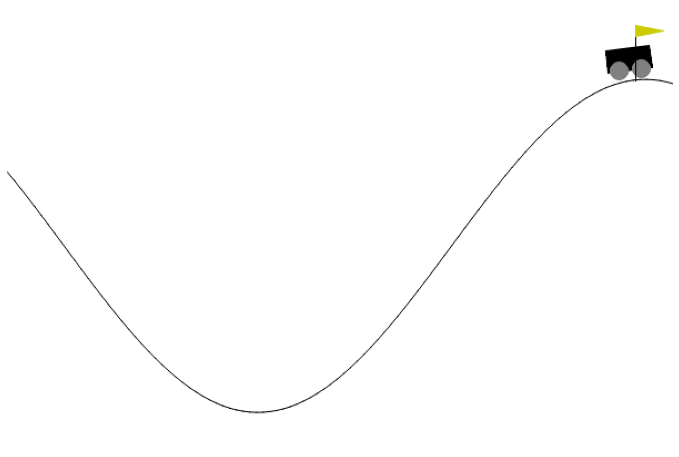

In [426]:
trajectory = get_trajectory(env, SARSA_agent, trajectory_len, visualize=True, filename='sarsa_car.gif', fps=120)

print(np.sum(trajectory['rewards']))

In [428]:
#np.save('sarsa_car.npy', sarsa_q_values)
#CE_agent.model = np.load('ce_taxi.npy', allow_pickle=True)

### Monte Carlo

Обучиться, используя исходный алгоритм не получилось. Я добавил возможность выбора параметра $ \alpha $, аналогично тому как он используется в алгоритма SARSA и Q-learning. Кроме того понадобилось сильно больше эпизодов чем в других алгоритмах.

In [21]:
episode_n = 100000
gamma = 0.9
trajectory_len = 200

In [22]:
mc_rewards, mc_q_values = QLearning(env, episode_n, gamma,  trajectory_len, gamma / 3, continuous_state=True, 
                                    point_n=10, eps_strategy=lambda x, n: 1 - x**(0.5) / n**(0.5))

100%|██████████| 100000/100000 [56:35<00:00, 29.45it/s] 


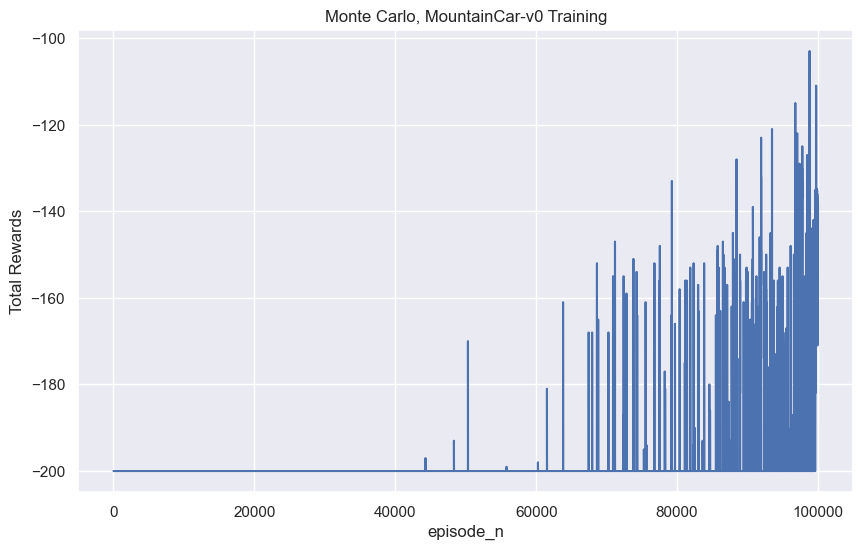

In [24]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Monte Carlo, MountainCar-v0 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Total Rewards')

plt.plot(mc_rewards)
plt.savefig('mc_car.png')

In [28]:
MC_agent = Agent(env, state_dim, action_n, continuous_state=True, point_n=10)
MC_agent.get_model(mc_q_values)

100%|██████████| 100/100 [00:00<00:00, 20004.31it/s]


In [29]:
validation_n = 1000
validation_score = validation(env, MC_agent, trajectory_len, validation_n)
print(f'Monte Carlo algorithm validation_score: {validation_score}')

Monte Carlo algorithm validation_score: -151.176


MovieWriter imagemagick unavailable; using Pillow instead.


-140.0


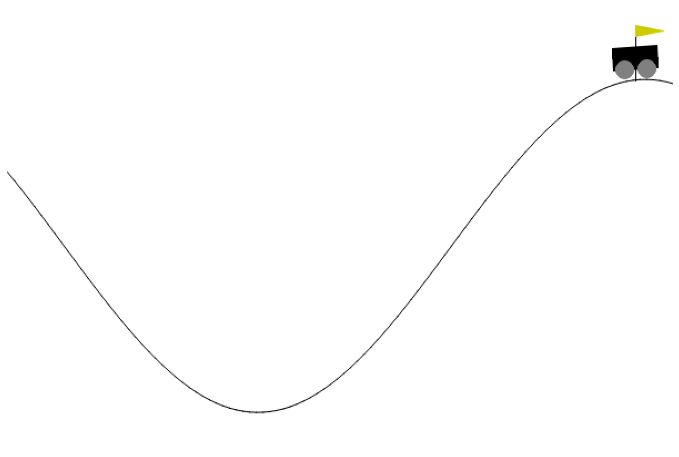

In [30]:
trajectory = get_trajectory(env, MC_agent, trajectory_len, visualize=True, filename='mc_car.gif', fps=120)

print(np.sum(trajectory['rewards']))

In [31]:
np.save('mc_car.npy', mc_q_values)
#CE_agent.model = np.load('ce_taxi.npy', allow_pickle=True)

## Задание 3 ##

Придумать стратегию для выбора $ \varepsilon $ позволяющую агенту наилучшим образом решать Taxi-v3 алгоритмом Monte Carlo.

In [155]:
env = gym.make("Taxi-v3")

state_n = 500
action_n = 6

Рассмотрим несколько убывающих функций от 1 до 0 на $ x \in \mathbb{R} $:

In [156]:
def eps1(x, n=0):
    return 1 / (x + 1)

def eps2(x, n=0):
    return 1 / np.sqrt(x + 1)

def eps3(x, n=0):
    return np.exp(-x)

def eps4(x, n=0):
    return -np.tanh(x) + 1

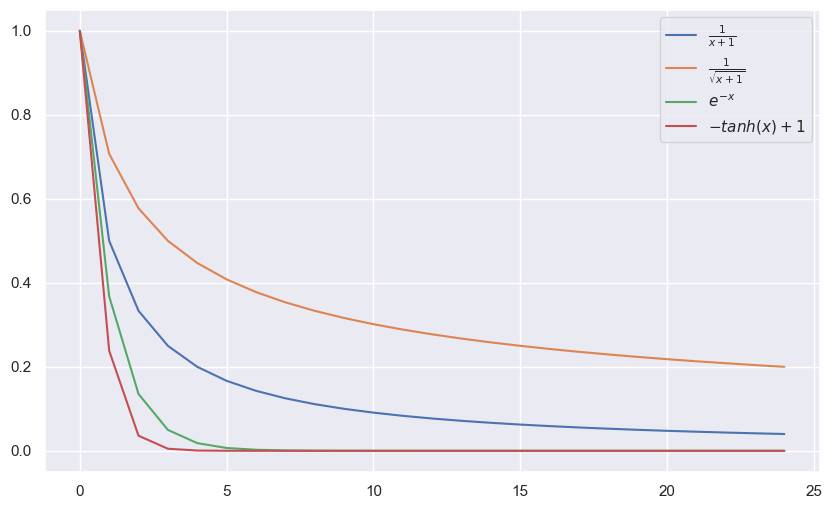

In [157]:
fig, axs = plt.subplots(figsize=(10, 6))

x = np.arange(0, 25, 1)

axs.plot(x, eps1(x), label=r'$ \frac{1}{x + 1} $ ')
axs.plot(x, eps2(x), label=r'$ \frac{1}{\sqrt{x + 1}} $')
axs.plot(x, eps3(x), label=r'$ e^{-x} $')
axs.plot(x, eps4(x), label=r'$ -tanh(x) + 1 $')

axs.legend()

In [169]:
episode_n = 10000
gamma = 0.9
trajectory_len = 100

  0%|          | 10/10000 [00:00<01:41, 98.04it/s]

100%|██████████| 10000/10000 [01:19<00:00, 126.21it/s]


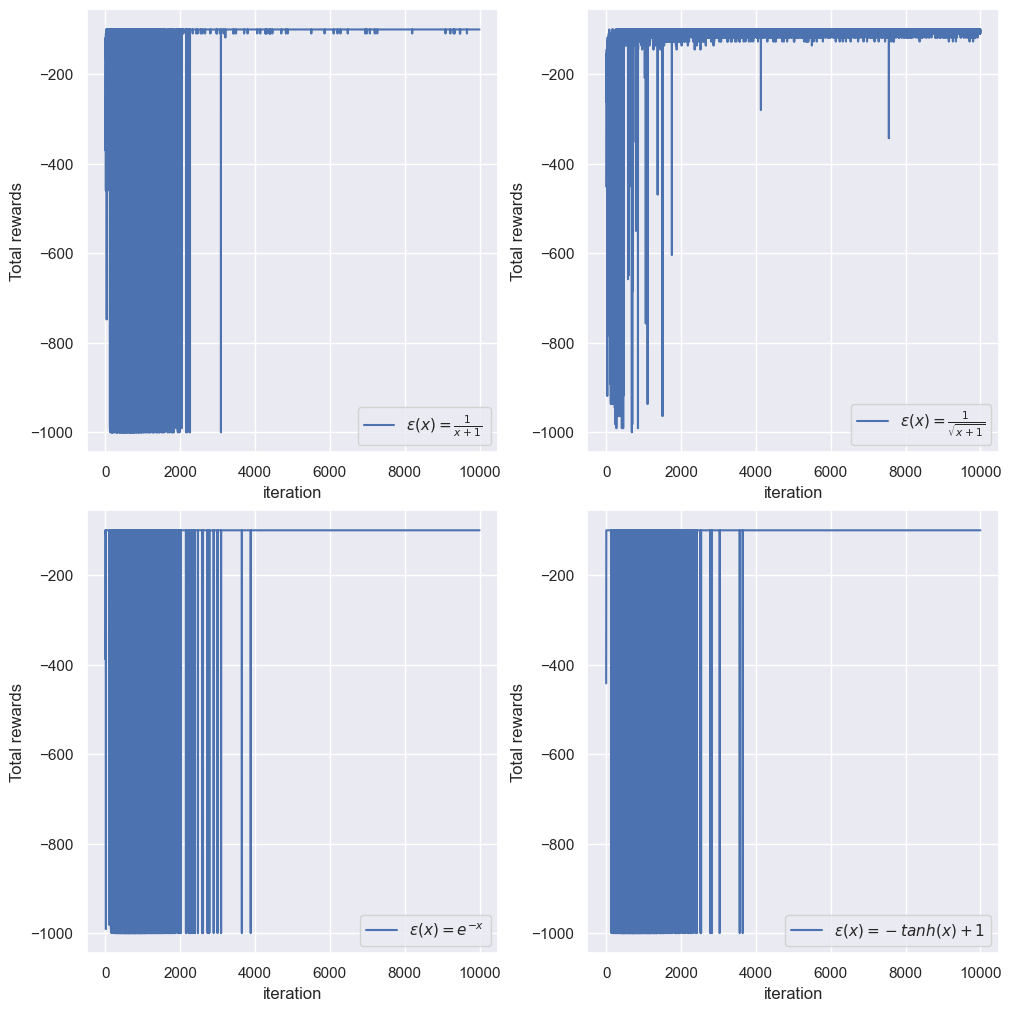

In [184]:
fig, axs = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, layout="constrained")

mc_rewards_eps = []
mc_q_values_eps = []
eps_strategies = [eps1, eps2, eps3, eps4]
labels = [
    r'$ \varepsilon(x) = \frac{1}{x + 1} $ ', 
    r'$ \varepsilon(x) = \frac{1}{\sqrt{x + 1}} $',
    r'$ \varepsilon(x) = e^{-x} $', 
    r'$ \varepsilon(x) = -tanh(x) + 1 $'
]

for i in range(4):
    mc_rewards, mc_q_values = MonteCarlo(env, episode_n, trajectory_len, gamma, eps_strategy=eps_strategies[i])
    mc_rewards_eps.append(mc_rewards)
    mc_q_values_eps.append(mc_q_values)
    axs[i // 2, i % 2].plot(mc_rewards, label=labels[i])
    axs[i // 2, i % 2].set_xlabel('iteration')
    axs[i // 2, i % 2].set_ylabel('Total rewards')
    axs[i // 2, i % 2].legend()

In [192]:
validation_n = 100
MC_agents = [Agent(env, state_n, action_n) for _ in range(4)]
for i in range(4):
    MC_agents[i].get_model(mc_q_values_eps[i])
    validation_score = validation(env, MC_agents[i], trajectory_len, validation_n)
    print(f'Monte Carlo algorithm, eps{5 + i} validation_score: {validation_score}')

Monte Carlo algorithm, eps5 validation_score: -100.0
Monte Carlo algorithm, eps6 validation_score: -100.0
Monte Carlo algorithm, eps7 validation_score: -100.0
Monte Carlo algorithm, eps8 validation_score: -100.0


C такими эпсилонами на таком количестве эпизодов получилось обучиться только тому, чтобы не пытаться подбирать пассажира вообще.

Еще стоит попробовать функции, которые интерполируют точки (1, 0) и (0, episode_n). У таких фукнций параметр $ \varepsilon $ будет равняться 1 на первой итерации алгоритма и 0 на последней итерации алгоритма.

Рассмотрим несколько убывающих функций от 1 до 0 на $ x \in [0, n] $:

In [163]:
def eps5(x, n):
    return 1 - x / n

def eps6(x, n):
    return 1 - x**(0.5) / n**(0.5)

def eps7(x, n):
    return 1 - x**2 / n**2

def eps8(x, n):
    return 1 - x**(0.25) / n**(0.25)

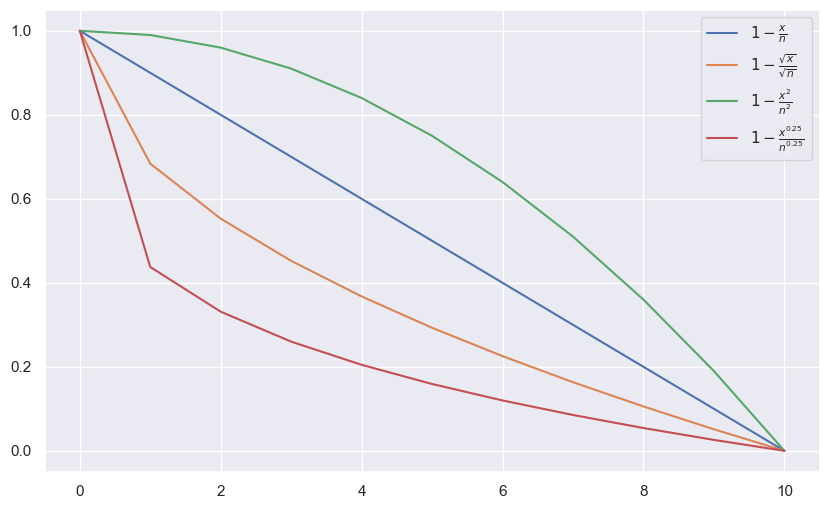

In [164]:
fig, axs = plt.subplots(figsize=(10, 6))

n = 10
x = np.arange(0, n + 1, 1)

axs.plot(x, eps5(x, n), label=r'$ 1 - \frac{x}{n} $ ')
axs.plot(x, eps6(x, n), label=r'$ 1 - \frac{\sqrt{x}}{\sqrt{n}} $')
axs.plot(x, eps7(x, n), label=r'$ 1 - \frac{x^2}{n^2} $ ')
axs.plot(x, eps8(x, n), label=r'$ 1 - \frac{x^{0.25}}{n^{0.25}} $ ')

axs.legend()

In [171]:
episode_n = 10000
gamma = 0.9
trajectory_len = 100

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:52<00:00, 189.29it/s]


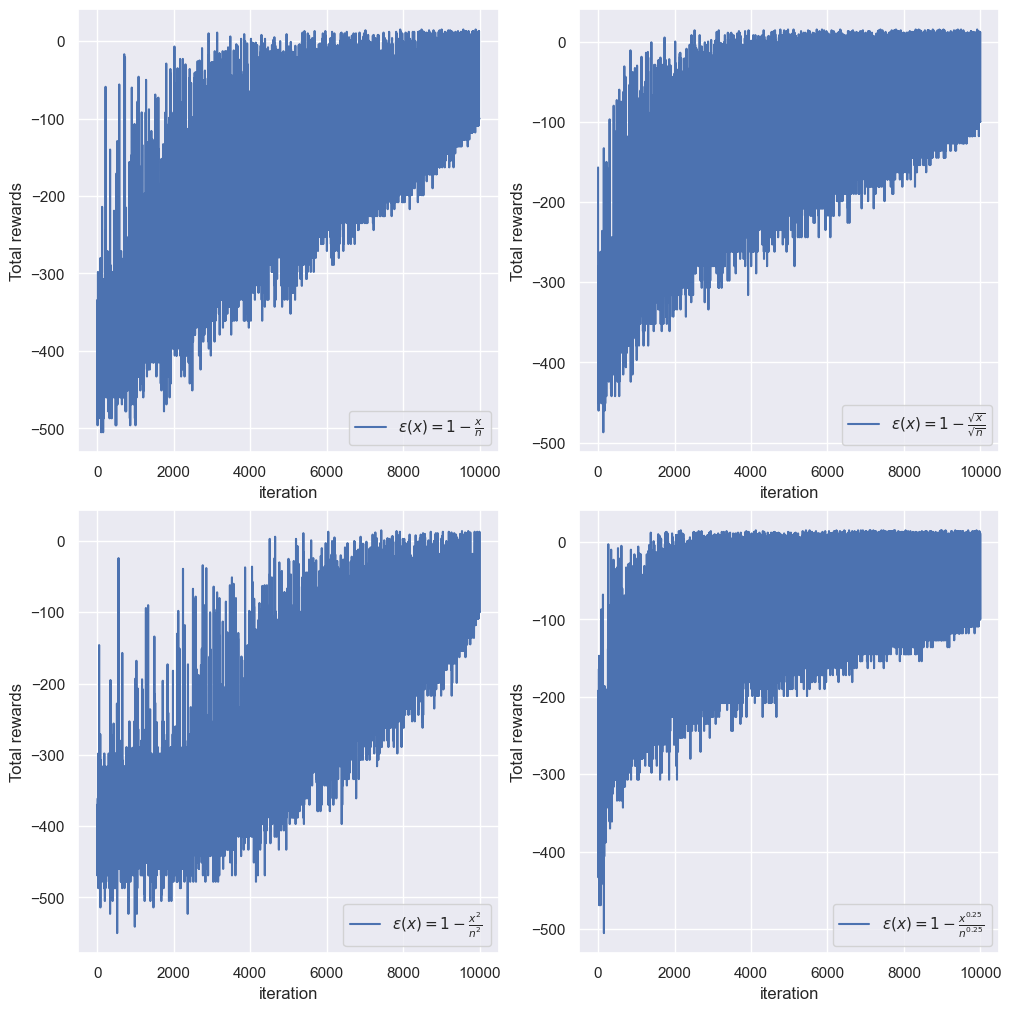

In [172]:
fig, axs = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, layout="constrained")

mc_rewards_eps = []
mc_q_values_eps = []
eps_strategies = [eps5, eps6, eps7, eps8]
labels = [
    r'$ \varepsilon(x) =  1 - \frac{x}{n} $ ', 
    r'$ \varepsilon(x) =  1 - \frac{\sqrt{x}}{\sqrt{n}} $',
    r'$ \varepsilon(x) =  1 - \frac{x^2}{n^2} $ ', 
    r'$ \varepsilon(x) =  1 - \frac{x^{0.25}}{n^{0.25}} $ '
]

for i in range(4):
    mc_rewards, mc_q_values = MonteCarlo(env, episode_n, trajectory_len, gamma, eps_strategy=eps_strategies[i])
    mc_rewards_eps.append(mc_rewards)
    mc_q_values_eps.append(mc_q_values)
    axs[i // 2, i % 2].plot(mc_rewards, label=labels[i])
    axs[i // 2, i % 2].set_xlabel('iteration')
    axs[i // 2, i % 2].set_ylabel('Total rewards')
    axs[i // 2, i % 2].legend()

In [175]:
validation_n = 1000
MC_agents = [Agent(env, state_n, action_n) for _ in range(4)]
for i in range(4):
    MC_agents[i].get_model(mc_q_values_eps[i])
    validation_score = validation(env, MC_agents[i], trajectory_len, validation_n)
    print(f'Monte Carlo algorithm, eps{5 + i} validation_score: {validation_score}')

Monte Carlo algorithm, eps5 validation_score: -90.32
Monte Carlo algorithm, eps6 validation_score: -79.156
Monte Carlo algorithm, eps7 validation_score: -97.062
Monte Carlo algorithm, eps8 validation_score: -73.993


Из полученного можно выдвинуть гипотезу о том, что чем меньше параметр $ \alpha $ в $ \varepsilon(x) = 1 - \frac{x^{\alpha}}{n^\alpha} $, тем лучше обучается алгоритм. Попробуем еще меньше:

In [176]:
def eps9(x, n):
    return 1 - x**(0.1) / n**(0.1)

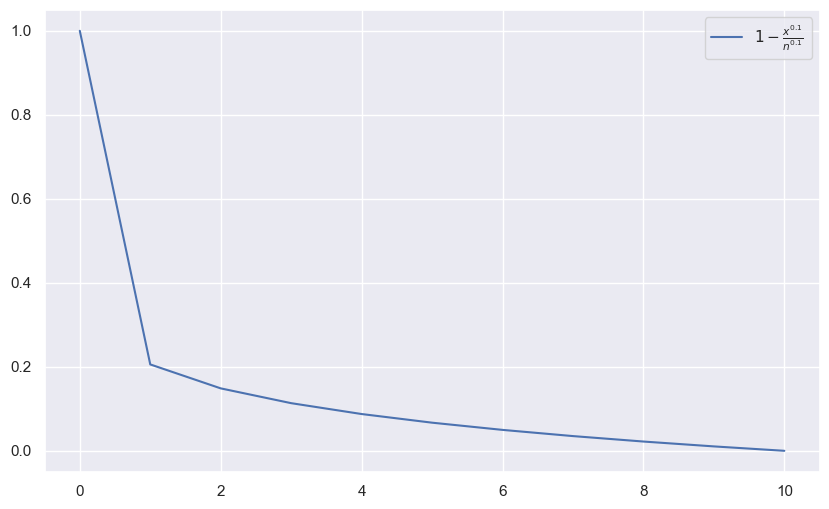

In [177]:
fig, axs = plt.subplots(figsize=(10, 6))

n = 10
x = np.arange(0, n + 1, 1)

axs.plot(x, eps9(x, n), label=r'$ 1 - \frac{x^{0.1}}{n^{0.1}} $ ')

axs.legend()

In [178]:
episode_n = 10000
gamma = 0.9
trajectory_len = 100

In [179]:
mc_rewards, mc_q_values = MonteCarlo(env, episode_n, trajectory_len, gamma, eps_strategy=eps9)

100%|██████████| 10000/10000 [01:08<00:00, 146.72it/s]


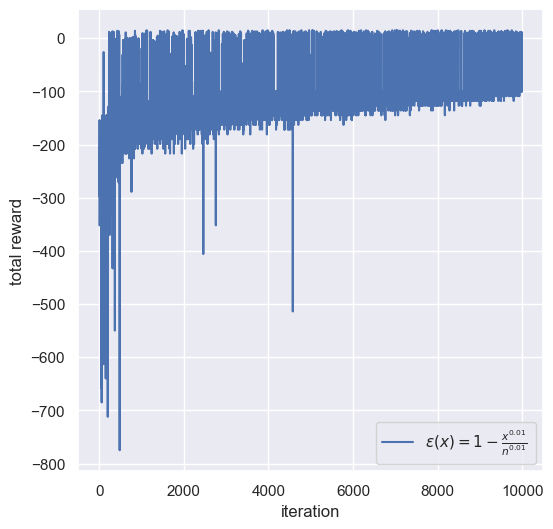

In [180]:
fig, axs = plt.subplots(figsize=(6, 6))
axs.plot(mc_rewards, label=r'$ \varepsilon(x) =  1 - \frac{x^{0.01}}{n^{0.01}} $ ')
axs.set_xlabel('iteration')
axs.set_ylabel('total reward')
axs.legend()

In [183]:
validation_n = 100
MC_agent = Agent(env, state_n, action_n)
MC_agent.get_model(mc_q_values)
validation_score = validation(env, MC_agent, trajectory_len, validation_n)
print(f'Monte Carlo algorithm, eps9 validation_score: {validation_score}')

Monte Carlo algorithm, eps9 validation_score: -92.25


Таким образом, наилучший результат был получен для следующих гиперпараметров:

```python

episode_n = 10000
gamma = 0.9
trajectory_len = 100

```

с функцией для $ \varepsilon(x) $:

$$
\varepsilon(x) = 1 - \frac{x^{0.25}}{n^{0.25}} \,\, ,
$$
где $ n $ - количество эпизодов алгоритма 


Для увлечения точности следует увеличивать количество эпизодов.